In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

# Constants
g = 32.17  # ft/s^2
celsius_to_kelvin = 273.15  # K

## Aircraft Data

In [ ]:
mmo = 0.85
Nz_limit = 6.0
b = 38.1  # wing span [ft]
S = 255  # wing area [ft^2]
AR = b**2 / S  # aspect ratio
e = 0.8  # Oswald efficiency factor
Ws = 11900  # Standard Weight [lb]

## Data for plot

In [ ]:
Vs = 123  # Stall speed IAS [kts]
altitude = 15000  # Altitude to plot [ft]

## Airspeed Calculations

In [4]:
def calc_vt_from_vc(atm, vc_fps, h):
    qc = atm.calc_qc(vc_fps)
    Pa = atm.calc_Pa(h)
    ve_fps = atm.calc_ve(Pa, qc)
    ve = atm.fps_to_kts(ve_fps)
    vt = atm.calc_vt(ve, h)
    return vt

## Load Level Acceleration Data

In [ ]:
level_accel_data = pd.read_excel("./demo_data/level_accel_data.xlsx", header=1)

## Data Analysis

In [ ]:
def fit_quadratic(time, vt_fps):
    # Perform quadratic regression using numpy
    coefficients = np.polyfit(time, vt_fps, 2)
    a, b, c = coefficients

    # Generate the fitted values
    vt_fitted = a * time**2 + b * time + c
    return vt_fitted


def calculate_sep(row):
    term1 = (row["Wt [lbs]"] / Ws) * (row["Vt [kts]"] / g) * row["dVt/dt [ft/s^2]"]
    term2 = (
        2
        / (
            np.pi
            * AR
            * e
            * atm.rho_0
            * atm.get_std_sigma(row["Hc [ft]"])
            * row["Vt [kts]"]
            * S
        )
    ) * ((row["Wt [lbs]"] ** 2 - Ws**2) / Ws)
    return term1 + term2


def calculate_nz(row):
    term1 = (row["Wt [lbs]"] / Ws) ** 2
    term2 = (np.pi * AR * e * row["qc [psf]"] * S) / Ws**2
    term3 = (row["Wt [lbs]"] / g) * row["dVt/dt [ft/s^2]"]
    return np.sqrt(term1 + term2 * term3)

### Apply to Data

In [ ]:
level_accel_data["Wt [lbs]"] = level_accel_data.apply(
    lambda row: row["ZFW [lbs]"] + row["Wf [lbs]"], axis=1
)
level_accel_data["Hc [ft]"] = level_accel_data.apply(
    lambda row: row["Hi [ft]"] + row["ΔHpc (AFM) [ft]"] + row["ΔVic (AFM) [kts]"],
    axis=1,
)
level_accel_data["Vc [kts]"] = level_accel_data.apply(
    lambda row: row["Vi [kts]"] + row["ΔVic (AFM) [kts]"] + row["ΔVpc (AFM) [kts]"],
    axis=1,
)
level_accel_data["Vc [fps]"] = level_accel_data.apply(
    lambda row: atm.kts_to_fps(row["Vc [kts]"]), axis=1
)
level_accel_data["Vt [kts]"] = level_accel_data.apply(
    lambda row: calc_vt_from_vc(atm, row["Vc [fps]"], row["Hc [ft]"]), axis=1
)
level_accel_data["Vt [fps]"] = level_accel_data.apply(
    lambda row: atm.kts_to_fps(row["Vt [kts]"]), axis=1
)
level_accel_data["Mach"] = level_accel_data.apply(
    lambda row: atm.calc_mach(row["Vt [kts]"], row["Hc [ft]"]), axis=1
)
level_accel_data["qc [psf]"] = level_accel_data.apply(
    lambda row: atm.calc_qc(row["Vc [fps]"]), axis=1
)


# Extract the columns
time = level_accel_data["Time [s]"]
vt_fps = level_accel_data["Vt [fps]"]
# Apply the function to get the fitted values
level_accel_data["Vt_fitted [fps]"] = fit_quadratic(time, vt_fps)
level_accel_data["dVt/dt [ft/s^2]"] = np.gradient(
    level_accel_data["Vt_fitted [fps]"], level_accel_data["Time [s]"]
)
level_accel_data["sep [ft/s]"] = level_accel_data.apply(calculate_sep, axis=1)
level_accel_data["ROC [ft/min]"] = level_accel_data.apply(
    lambda row: row["sep [ft/s]"] * 60, axis=1
)
level_accel_data["nz [g]"] = level_accel_data.apply(calculate_nz, axis=1)
level_accel_data["Vts [fps]"] = level_accel_data.apply(
    lambda row: (
        row["Vt [fps]"] * np.sqrt((row["TT [℃]"] + celsius_to_kelvin) / atm.T_0)
    ),
    axis=1,
)
level_accel_data["ωs [rad/s]"] = level_accel_data.apply(
    lambda row: (g * np.sqrt(row["nz [g]"] ** 2 - 1) / row["Vts [fps]"]), axis=1
)
level_accel_data["ωs [deg/s]"] = level_accel_data.apply(
    lambda row: np.rad2deg(row["ωs [rad/s]"]), axis=1
)
level_accel_data["Rs [ft]"] = level_accel_data.apply(
    lambda row: (row["Vts [fps]"] ** 2) / (g * np.sqrt(row["nz [g]"] ** 2 - 1)), axis=1
)

In [8]:
level_accel_data

,Time [s],Vi [kts],Hi [ft],TT [℃],Wf [lbs],ZFW [lbs],ΔHic (AFM) [ft],ΔHpc (AFM) [ft],ΔVic (AFM) [kts],ΔVpc (AFM) [kts],...,qc [psf],Vt_fitted [fps],dVt/dt [ft/s^2],sep [ft/s],ROC [ft/min],nz [g],Vts [fps],ωs [rad/s],ωs [deg/s],Rs [ft]
0,0,140,15000,-5,3000,9000,0,0,0,0,...,67.105886,287.695462,3.538870,19.914327,1194.859630,1.816333,286.146908,0.170466,9.766979,1678.616302
1,10,150,15000,-5,3000,9000,0,0,0,0,...,77.162263,323.084165,3.451800,20.752839,1245.170342,1.891165,306.399215,0.168531,9.656094,1818.062397
2,20,165,15000,-5,3000,9000,0,0,0,0,...,93.618026,356.731471,3.277661,21.602924,1296.175438,1.991408,336.707551,0.164536,9.427247,2046.400355
3,30,178,15000,-5,3000,9000,0,0,0,0,...,109.228090,388.637378,3.103521,22.013515,1320.810896,2.067512,362.902227,0.160414,9.191019,2262.291641
4,40,198,15000,-5,3000,9000,0,0,0,0,...,135.732290,418.801888,2.929381,23.028765,1381.725909,2.199534,403.060596,0.156362,8.958864,2577.745592
5,50,220,15000,-5,3000,9000,0,0,0,0,...,168.449062,447.225001,2.755241,23.980202,1438.812132,2.340316,447.023188,0.152271,8.724508,2935.700536
6,60,230,15000,-5,3000,9000,0,0,0,0,...,184.581869,473.906715,2.581102,23.459238,1407.554292,2.365448,466.928728,0.147693,8.462179,3161.484368
7,70,240,15000,-5,3000,9000,0,0,0,0,...,201.518396,498.847032,2.406962,22.803434,1368.206012,2.382899,486.783959,0.142940,8.189874,3405.506104
8,80,248,15000,-5,3000,9000,0,0,0,0,...,215.654075,522.045952,2.232822,21.844909,1310.694525,2.375771,502.631090,0.137931,7.902852,3644.082141
9,90,256,15000,-5,3000,9000,0,0,0,0,...,230.317750,543.503473,2.058682,20.779285,1246.757130,2.360826,518.444646,0.132701,7.603184,3906.874968


## Plot Climb Performance

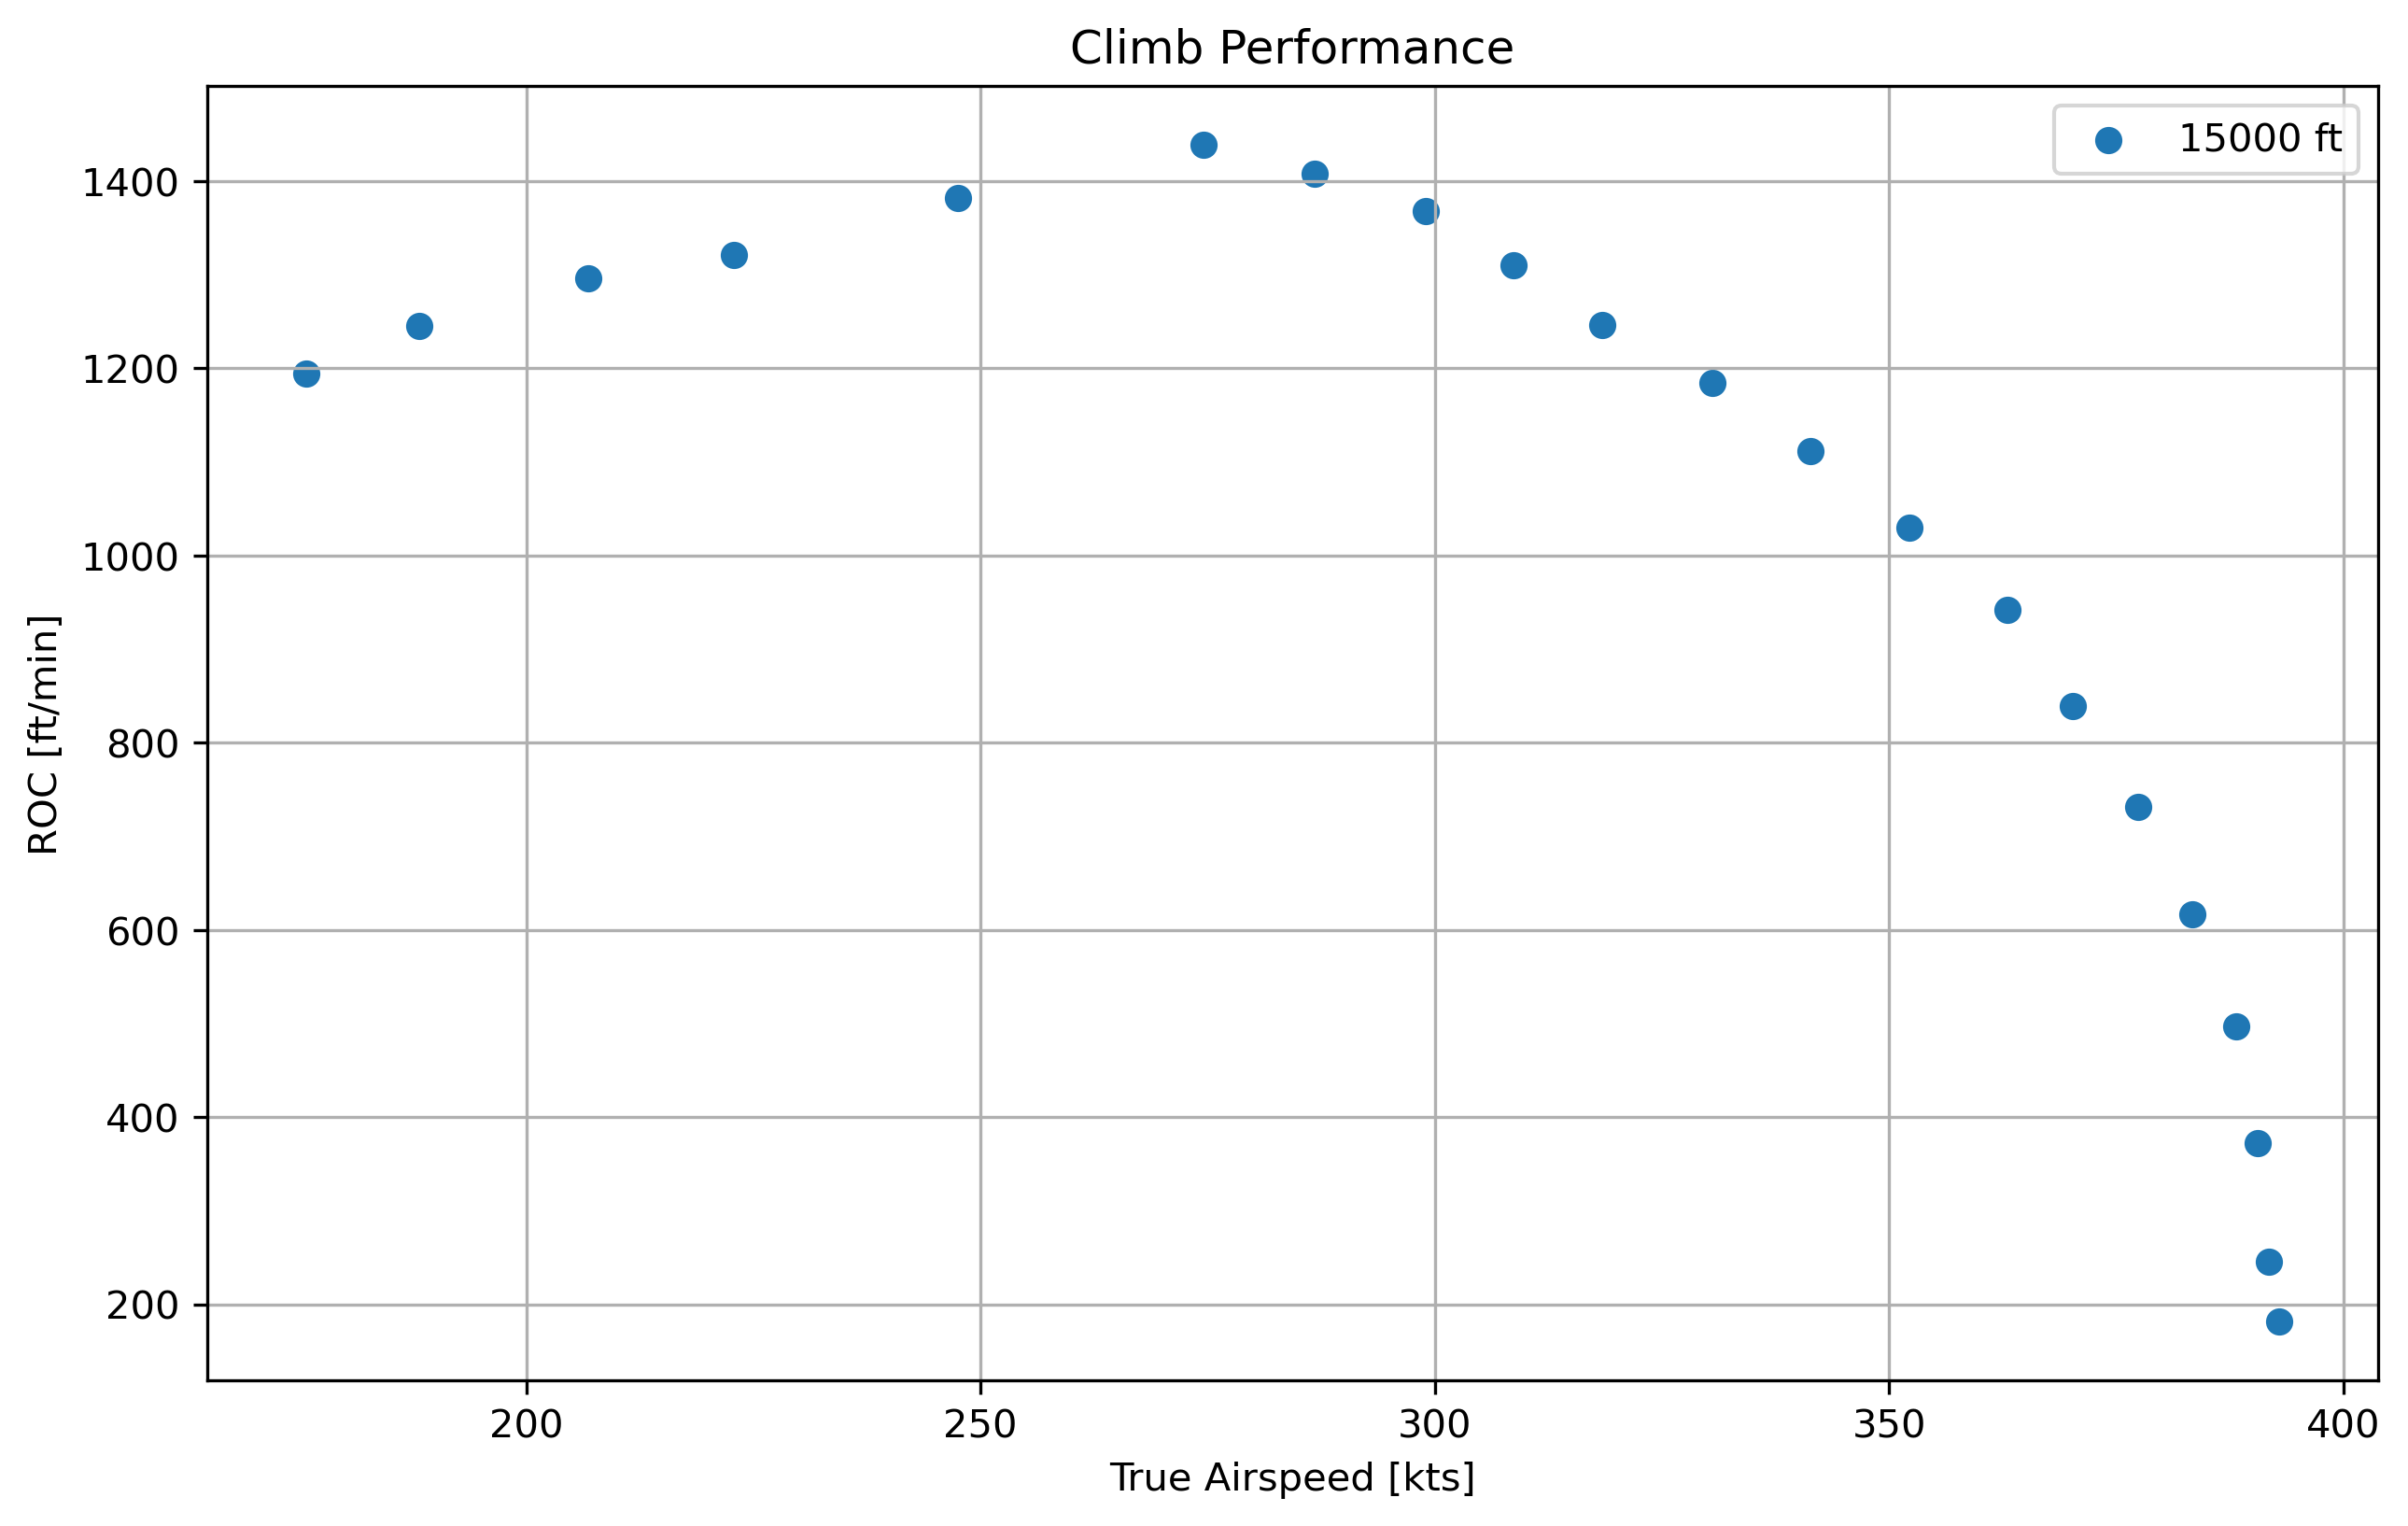

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(
    level_accel_data["Vt [kts]"],
    level_accel_data["ROC [ft/min]"],
    label=f"{altitude} ft",
)

plt.xlabel("True Airspeed [kts]")
plt.ylabel("ROC [ft/min]")
plt.title("Climb Performance")
plt.legend()
plt.grid()
plt.show()

## Create SEP Boundary limits

In [ ]:
g_space = np.linspace(1, Nz_limit, 1000)
sigma = atm.get_std_sigma(altitude)
lift_boundary_speeds = []
for g_step in g_space:
    lift_boundary_speeds.append(Vs * (np.sqrt(g_step) / np.sqrt(sigma)))

lift_boundary_turn_rates = []
for i, g_step in enumerate(g_space):
    lift_boundary_turn_rates.append(
        np.rad2deg(g * np.sqrt(g_step**2 - 1) / atm.kts_to_fps(lift_boundary_speeds[i]))
    )

max_lift_speed = max(lift_boundary_speeds)
max_speed = atm.calc_vt_from_mach(mmo, altitude)

nz_boundary_speeds = np.linspace(max_lift_speed, max_speed, 100)
nz_boundary_turn_rates = []
for speed in nz_boundary_speeds:
    nz_boundary_turn_rates.append(
        np.rad2deg(g * np.sqrt(Nz_limit**2 - 1) / atm.kts_to_fps(speed))
    )

mmo_speeds = np.array([max_speed, max_speed])
mmo_turn_rates = np.array([0])
mmo_turn_rates = np.append(
    mmo_turn_rates, np.rad2deg(g * np.sqrt(Nz_limit**2 - 1) / atm.kts_to_fps(max_speed))
)

## Create fixed radius and g lines

In [ ]:
g_lines = np.array([1.1, 1.5, 2, 2.5, 3, 4, 5, 6, 7])
min_lift_boundary_speed = min(lift_boundary_speeds)
min_line_speed = min_lift_boundary_speed * 0.99
max_line_speed = max_speed * 1.02
lines_speeds = np.linspace(min_line_speed, max_line_speed, 100)

g_lines_turn_rates = []
for g_line in g_lines:
    turn_rates = []
    for speed in lines_speeds:
        turn_rate = np.rad2deg(g * np.sqrt(g_line**2 - 1) / atm.kts_to_fps(speed))
        turn_rates.append(turn_rate)
    g_lines_turn_rates.append(turn_rates)

# radius_lines = np.array([1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 8000, 10000, 15000, 20000])
radius_lines = np.array([1000, 1500, 2000, 2500, 3000, 4000, 6000])
radius_lines_turn_rates = []
radius_lines_speeds = [min_line_speed, max_line_speed]
for radius in radius_lines:
    turn_rates = []
    for speed in radius_lines_speeds:
        turn_rate = np.rad2deg(speed / radius)
        turn_rates.append(turn_rate)
    radius_lines_turn_rates.append(turn_rates)

## Plot SEP

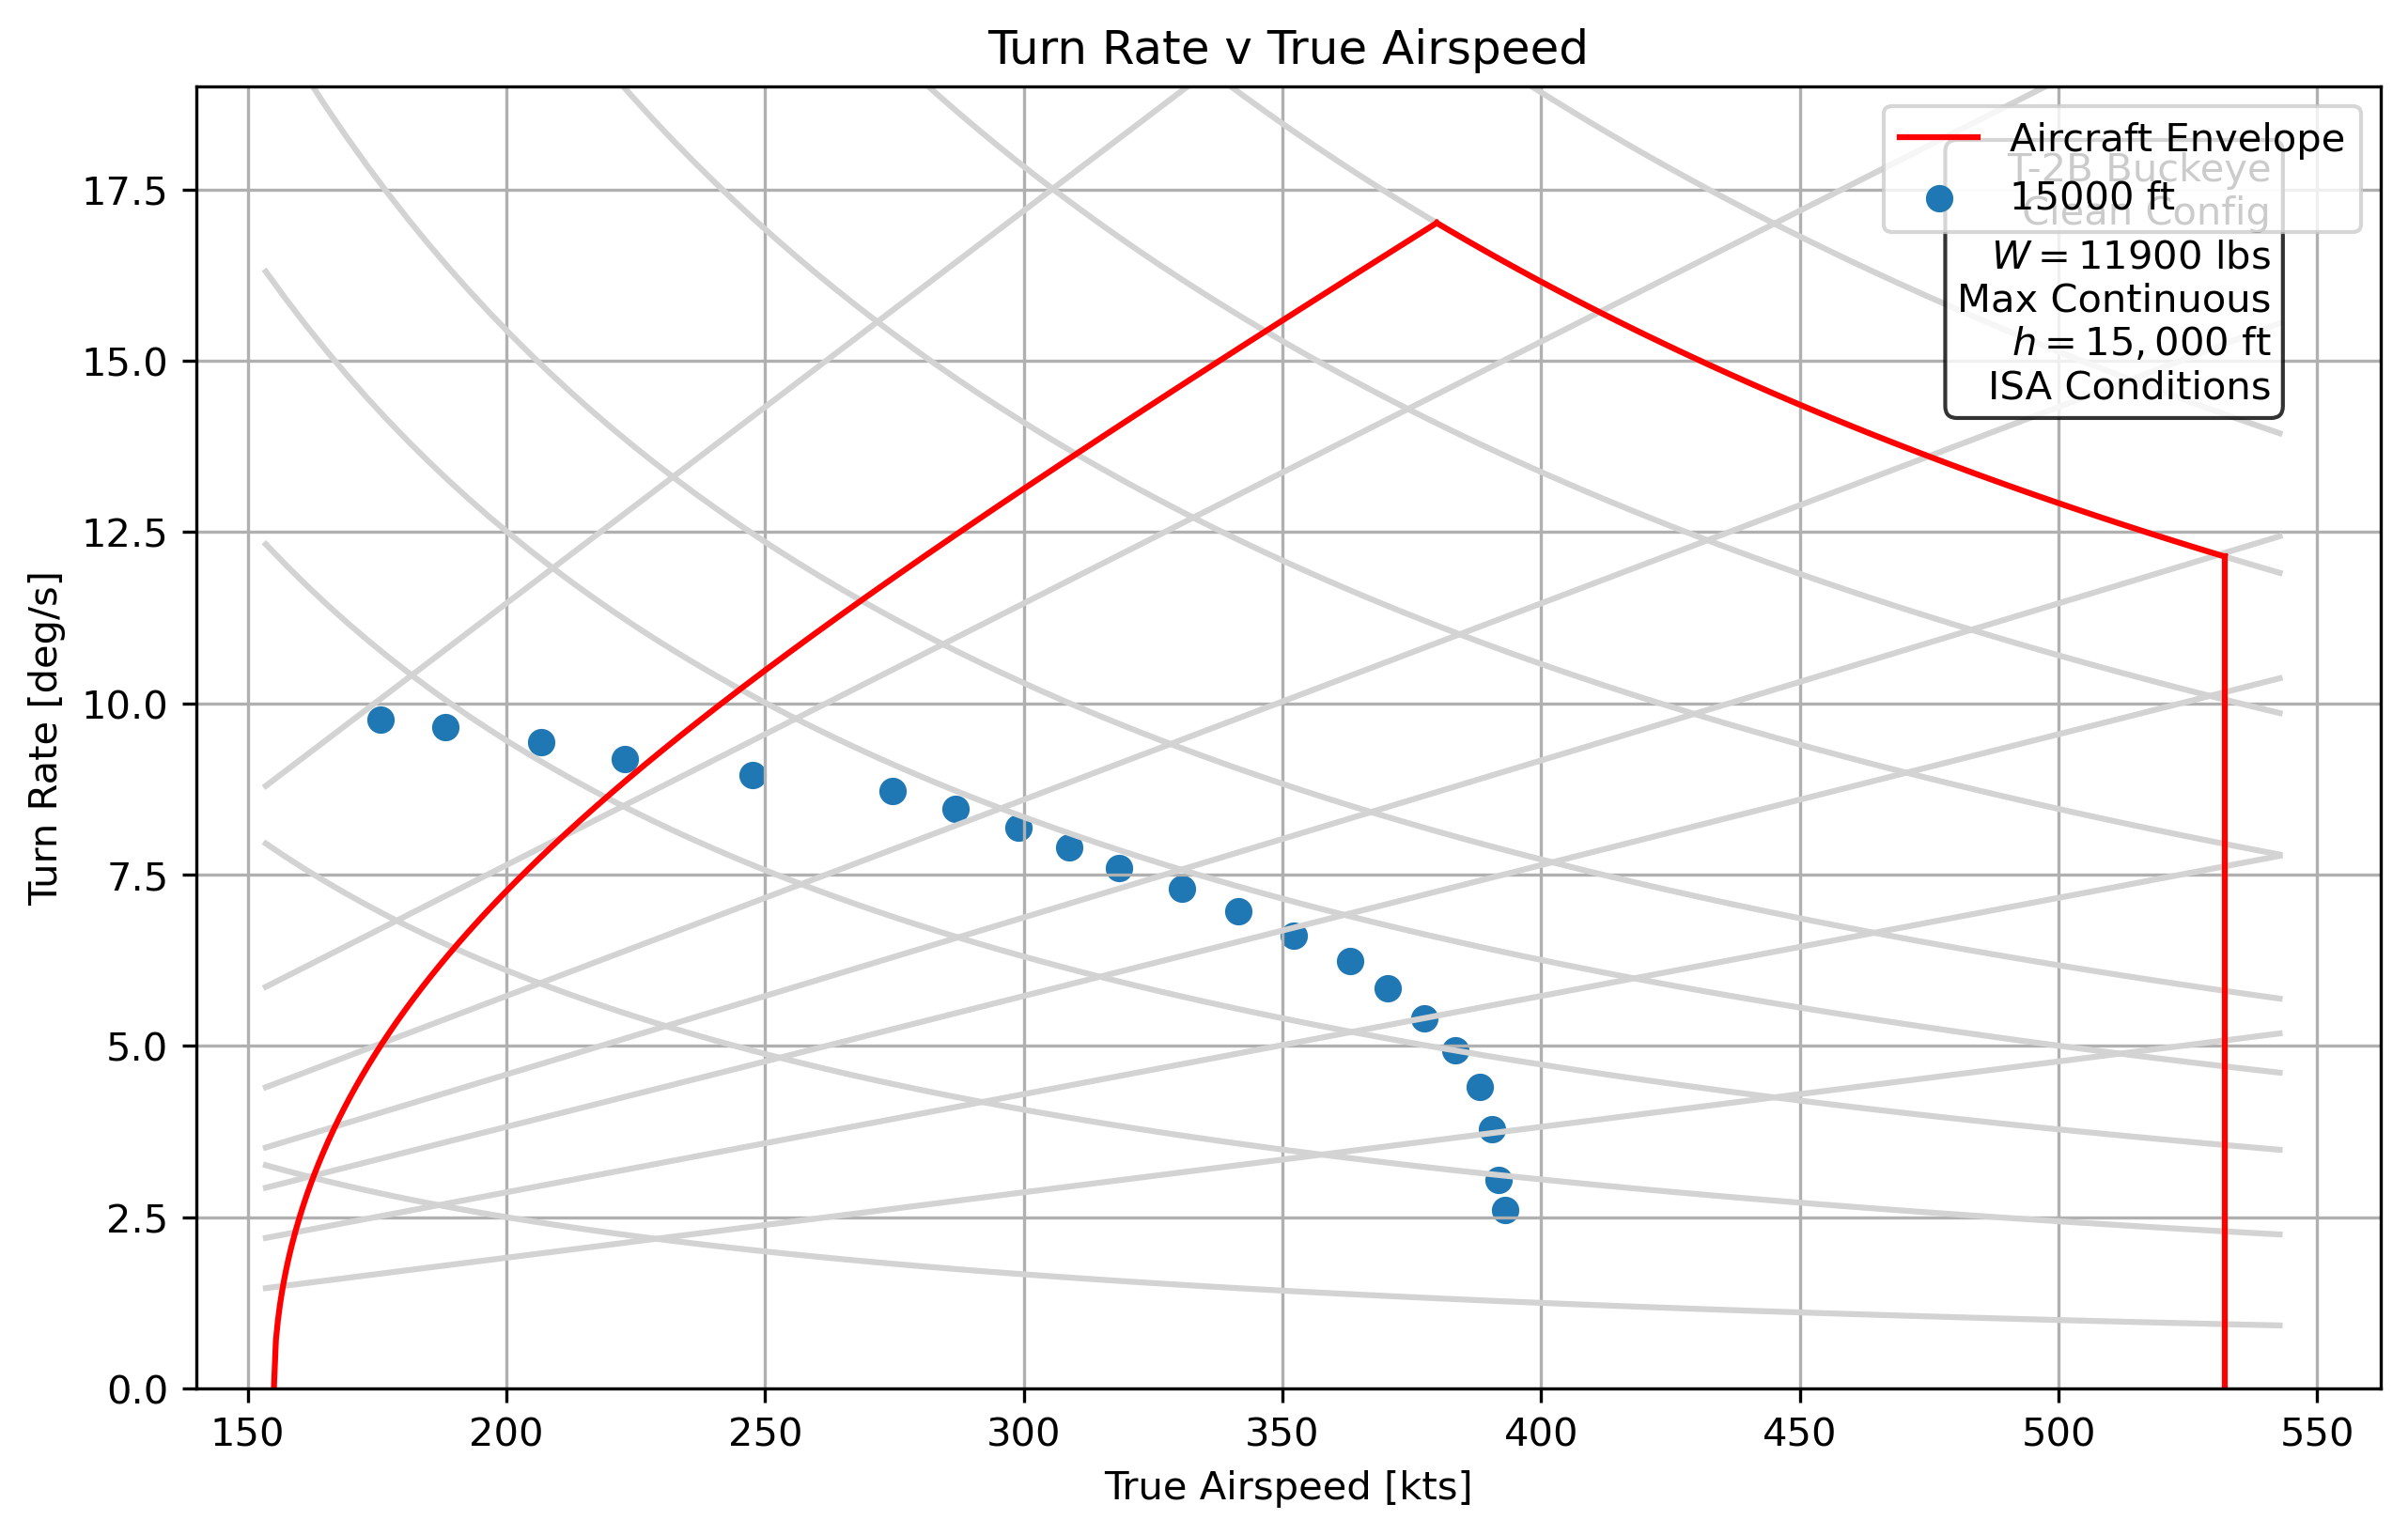

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)

for i in range(0, len(g_lines)):
    plt.plot(lines_speeds, g_lines_turn_rates[i], color="lightgray")

for i in range(0, len(radius_lines)):
    plt.plot(radius_lines_speeds, radius_lines_turn_rates[i], color="lightgray")

plt.plot(
    lift_boundary_speeds,
    lift_boundary_turn_rates,
    label="Aircraft Envelope",
    color="red",
)
plt.plot(nz_boundary_speeds, nz_boundary_turn_rates, color="red")
plt.plot(mmo_speeds, mmo_turn_rates, color="red")

plt.scatter(
    level_accel_data["Vt [kts]"], level_accel_data["ωs [deg/s]"], label=f"{altitude} ft"
)

textstr = "\n".join(
    (
        r"T-2B Buckeye",
        r"Clean Config",
        r"$W = 11900$ lbs",
        r"Max Continuous",
        r"$h = 15,000$ ft",
        r"ISA Conditions",
    )
)

# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    0.95,
    0.95,
    textstr,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)


plt.xlabel("True Airspeed [kts]")
plt.ylabel("Turn Rate [deg/s]")
plt.title("Turn Rate v True Airspeed")
plt.legend()
plt.grid()
plt.xlim(140, None)
plt.ylim(0, 19)
plt.show()